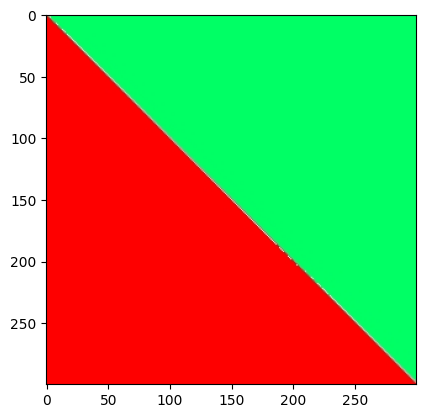

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

img = cv2.imread('merah_hijau.jpg')
plt.imshow( cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [38]:
b, g, r = cv2.split(img)

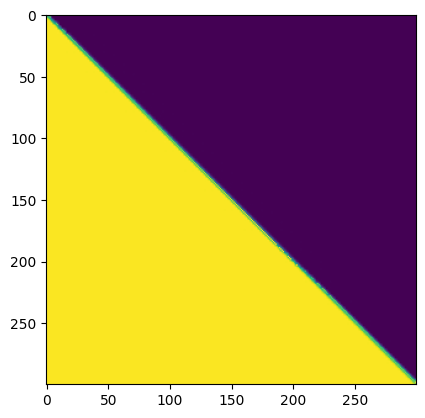

In [39]:
plt.imshow(r)

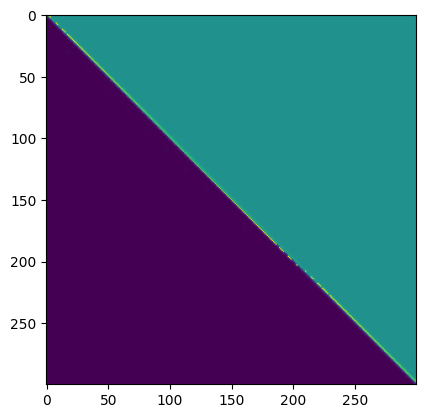

In [40]:
plt.imshow(b)

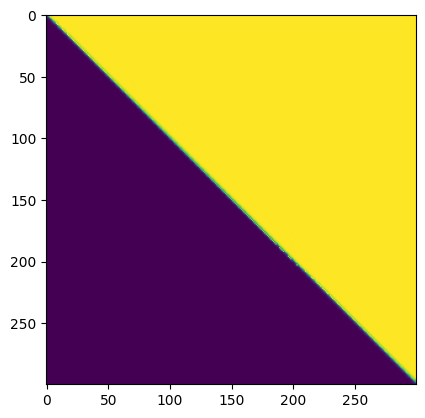

In [41]:
plt.imshow(g)

In [42]:
img_path = Path("merah_hijau.jpg")
out_dir  = Path("splits")
out_dir.mkdir(exist_ok=True)

img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)

b, g, r = cv2.split(img)

cv2.imwrite(str(out_dir / "red_channel.png"), r)
cv2.imwrite(str(out_dir / "green_channel.png"), g)
cv2.imwrite(str(out_dir / "blue_channel.png"), b)

zeros = np.zeros_like(r)
red_vis   = cv2.merge([zeros, zeros, r])
green_vis = cv2.merge([zeros, g, zeros])
blue_vis  = cv2.merge([b, zeros, zeros])

cv2.imwrite(str(out_dir / "red_visual.png"), red_vis)
cv2.imwrite(str(out_dir / "green_visual.png"), green_vis)
cv2.imwrite(str(out_dir / "blue_visual.png"), blue_vis)

print("Saved to:", out_dir.resolve())

Saved to: F:\Universitas Brawijaya\Semester Pendek\citra komputer\TugasKlpk\tugas_kel_pcdvk-1\tugas_kel_pcdvk\image_inpanting\splits


In [ ]:
img_path  = Path("merah_hijau.jpg")        
mask_path = Path("empty_mask.png")      
out_dir   = Path("out_inpainting_preview")
out_dir.mkdir(exist_ok=True)

img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
H, W = img.shape[:2]

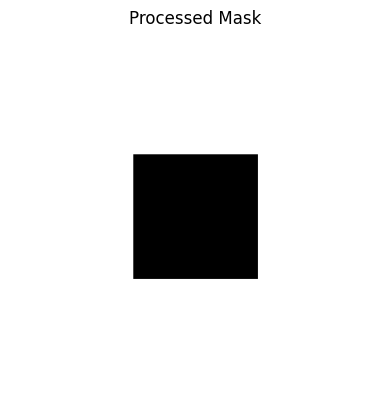

In [44]:
mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
assert mask is not None, f"Mask not found: {mask_path.resolve()}"
if mask.shape != (H, W):
    mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)
_, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

mask = cv2.bitwise_not(mask)

plt.imshow(mask, cmap="gray")
plt.title("Processed Mask")
plt.axis("off")
plt.show()

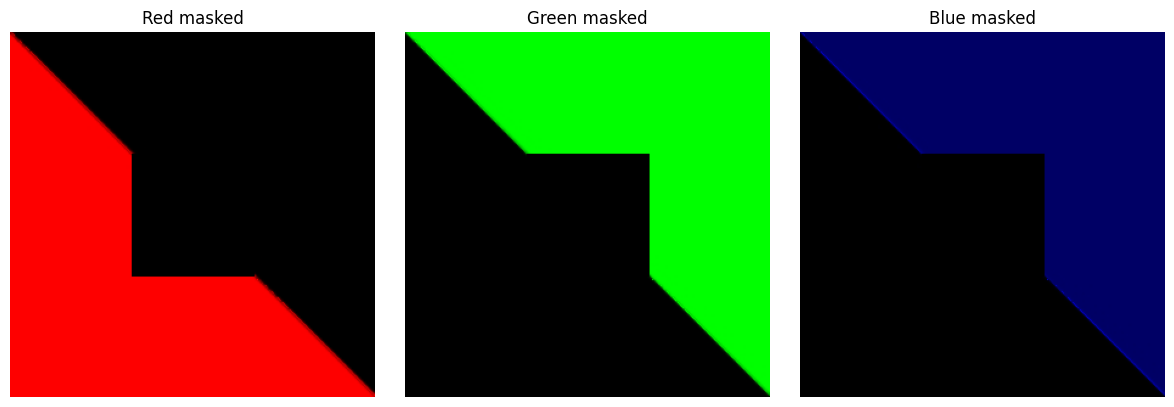

In [45]:
red_masked   = cv2.bitwise_and(red_vis,   red_vis,   mask=mask)
green_masked = cv2.bitwise_and(green_vis, green_vis, mask=mask)
blue_masked  = cv2.bitwise_and(blue_vis,  blue_vis,  mask=mask)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(red_masked, cv2.COLOR_BGR2RGB))
plt.title("Red masked"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(green_masked, cv2.COLOR_BGR2RGB))
plt.title("Green masked"); plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(blue_masked, cv2.COLOR_BGR2RGB))
plt.title("Blue masked"); plt.axis("off")

plt.tight_layout()
plt.show()

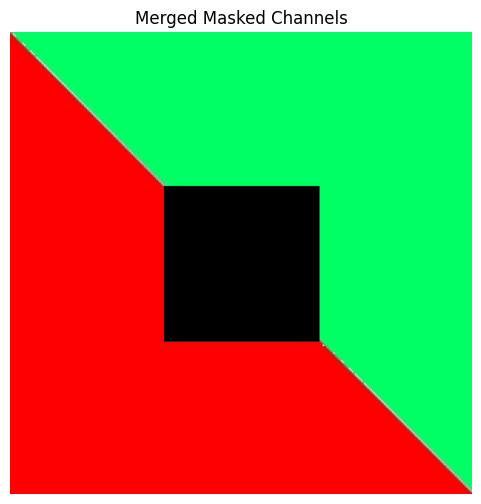

In [46]:
merged_vis = cv2.add(red_masked, cv2.add(green_masked, blue_masked))

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(merged_vis, cv2.COLOR_BGR2RGB))
plt.title("Merged Masked Channels")
plt.axis("off")
plt.show()


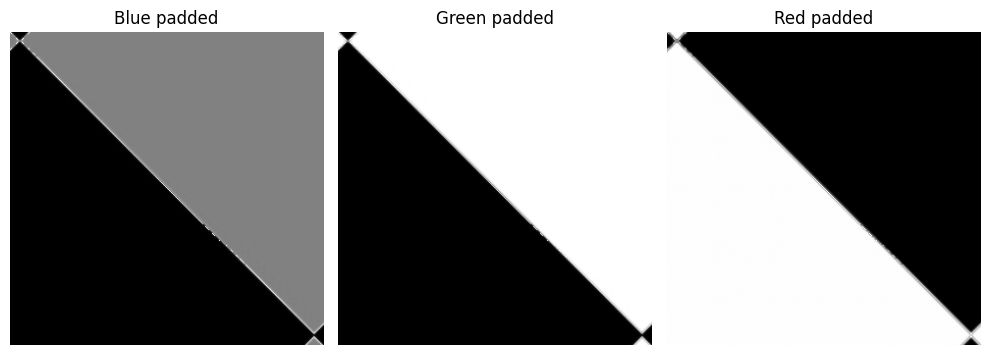

In [47]:
pad = 10   

b_pad = cv2.copyMakeBorder(b, pad, pad, pad, pad, borderType=cv2.BORDER_REFLECT)
g_pad = cv2.copyMakeBorder(g, pad, pad, pad, pad, borderType=cv2.BORDER_REFLECT)
r_pad = cv2.copyMakeBorder(r, pad, pad, pad, pad, borderType=cv2.BORDER_REFLECT)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(b_pad, cmap="gray"); plt.title("Blue padded"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(g_pad, cmap="gray"); plt.title("Green padded"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(r_pad, cmap="gray"); plt.title("Red padded"); plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
y, x = 50, 50    # ROI
k = 5            # kenel size

half = k // 2

b_kernel = b_pad[y-half:y+half+1, x-half:x+half+1]
g_kernel = g_pad[y-half:y+half+1, x-half:x+half+1]
r_kernel = r_pad[y-half:y+half+1, x-half:x+half+1]

print("Blue channel kernel ({}x{}):\n".format(k,k), b_kernel)
print("\nGreen channel kernel ({}x{}):\n".format(k,k), g_kernel)
print("\nRed channel kernel ({}x{}):\n".format(k,k), r_kernel)


Blue channel kernel (5x5):
 [[102 180 118 110 104]
 [ 32  99 187 118 110]
 [  9  23  97 184 118]
 [  0   9  32  98 174]
 [  0   3  10  23 102]]

Green channel kernel (5x5):
 [[124 233 219 242 251]
 [ 32 121 251 219 239]
 [ 11  31 119 237 219]
 [  0  11  32 120 238]
 [  0   4  11  31 124]]

Red channel kernel (5x5):
 [[176 183  64  22   7]
 [180 173 185  64  28]
 [229 185 171 187  64]
 [254 229 180 172 172]
 [254 246 229 185 176]]


In [ ]:
k = 5  
pad = k // 2

def windows_view_2d(arr: np.ndarray, k: int):
    """Return a view of shape (H, W, k, k) where each [y,x] is the k×k patch centered at (y,x)."""
    pad = k // 2
    arr_pad = cv2.copyMakeBorder(arr, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    s0, s1 = arr_pad.strides
    return np.lib.stride_tricks.as_strided(
        arr_pad,
        shape=(arr.shape[0], arr.shape[1], k, k),
        strides=(s0, s1, s0, s1),
        writeable=False
    )

# Build per-pixel kernel references (sliding-window views)
win_r = windows_view_2d(r, k)
win_g = windows_view_2d(g, k)
win_b = windows_view_2d(b, k)

# Example outputs
print("win_r shape:", win_r.shape, "-> per-pixel patches")
print("Kernel at center pixel (H//2, W//2) for R:\n", win_r[H//2, W//2])

# Per-pixel mean map (H×W)
mean_r = win_r.mean(axis=(2,3), dtype=np.float32)
mean_g = win_g.mean(axis=(2,3), dtype=np.float32)
mean_b = win_b.mean(axis=(2,3), dtype=np.float32)

print("Mean maps:", mean_r.shape, mean_g.shape, mean_b.shape)

win_r shape: (300, 300, 5, 5) -> per-pixel patches
Kernel at center pixel (H//2, W//2) for R:
 [[247 106  65  22   7]
 [180 245 101  64  28]
 [229 185 243 114  64]
 [254 229 180 243 107]
 [254 246 229 185 244]]
Mean maps: (300, 300) (300, 300) (300, 300)


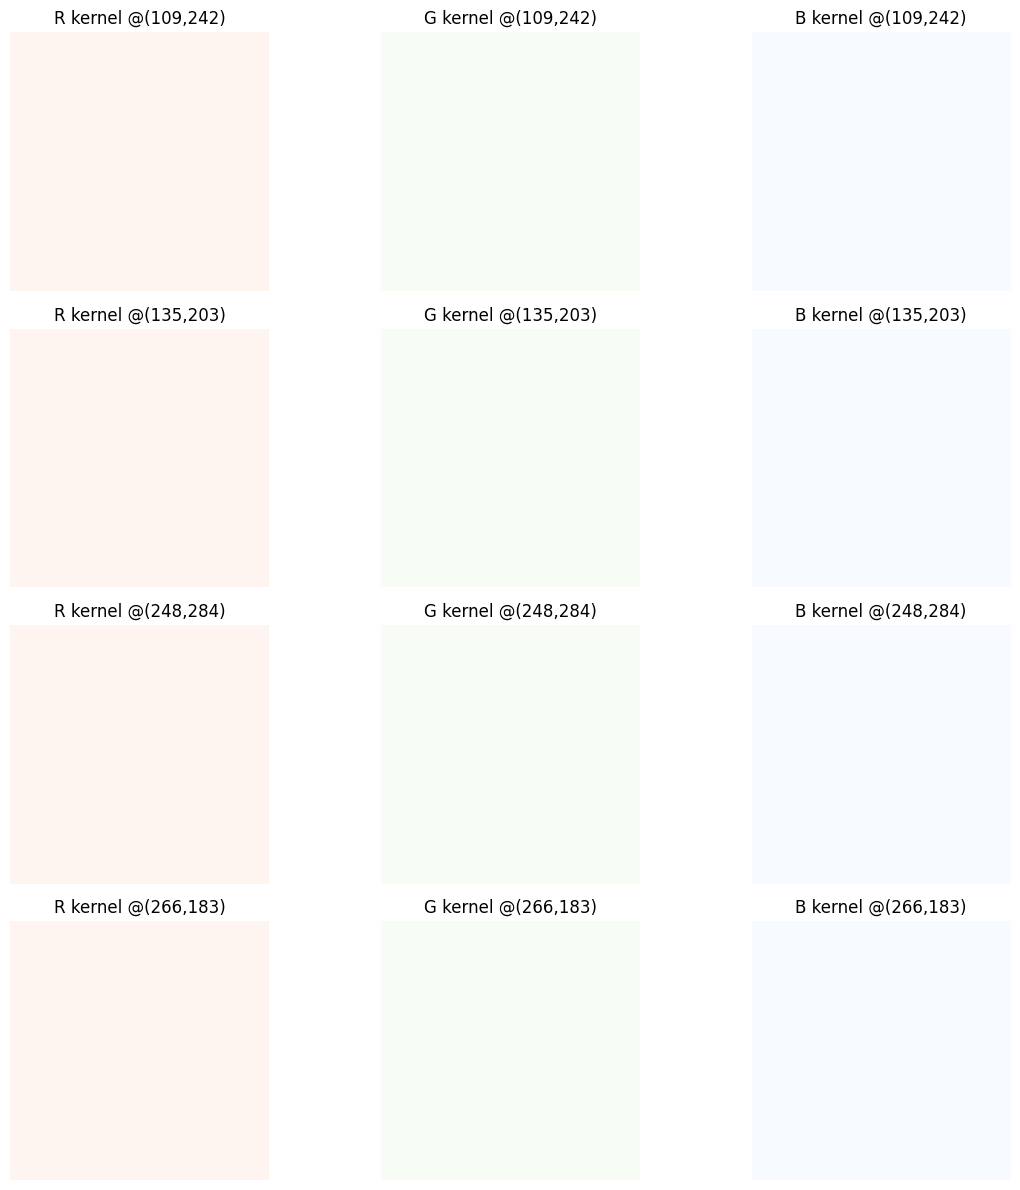


=== Sample 1 at (y=109, x=242) ===
R kernel:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
G kernel:
 [[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]
B kernel:
 [[101 101 101 101 101]
 [101 101 101 101 101]
 [101 101 101 101 101]
 [101 101 101 101 101]
 [101 101 101 101 101]]

=== Sample 2 at (y=135, x=203) ===
R kernel:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
G kernel:
 [[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]
B kernel:
 [[101 101 101 101 101]
 [101 101 101 101 101]
 [101 101 101 101 101]
 [101 101 101 101 101]
 [101 101 101 101 101]]

=== Sample 3 at (y=248, x=284) ===
R kernel:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
G kernel:
 [[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]
B kernel:
 [[101 101 101 1

In [ ]:
num_samples = 4   # how many kernels to show
ys = np.random.randint(0, H, size=num_samples)
xs = np.random.randint(0, W, size=num_samples)

plt.figure(figsize=(12, 3*num_samples))

for i, (y, x) in enumerate(zip(ys, xs)):
    r_patch = win_r[y, x]
    g_patch = win_g[y, x]
    b_patch = win_b[y, x]

    # visualize patches
    plt.subplot(num_samples, 3, 3*i+1)
    plt.imshow(r_patch, cmap="Reds"); plt.title(f"R kernel @({y},{x})"); plt.axis("off")

    plt.subplot(num_samples, 3, 3*i+2)
    plt.imshow(g_patch, cmap="Greens"); plt.title(f"G kernel @({y},{x})"); plt.axis("off")

    plt.subplot(num_samples, 3, 3*i+3)
    plt.imshow(b_patch, cmap="Blues"); plt.title(f"B kernel @({y},{x})"); plt.axis("off")

plt.tight_layout()
plt.show()

# print numeric values for the same kernels
for i, (y, x) in enumerate(zip(ys, xs), 1):
    print(f"\n=== Sample {i} at (y={y}, x={x}) ===")
    print("R kernel:\n", win_r[y, x])
    print("G kernel:\n", win_g[y, x])
    print("B kernel:\n", win_b[y, x])


In [51]:
ys, xs = np.where(mask > 0)   # hole pixels
ty, tx = ys[0], xs[0]
Pt = win_r[ty, tx]            # target patch (R channel for demo)

# Pick one sample pixel outside mask for Pr
ys_bg, xs_bg = np.where(mask == 0)  # known pixels
ry, rx = ys_bg[0], xs_bg[0]
Pr = win_r[ry, rx]                  # reference patch

# Compute distance
d_val = patch_distance(Pt, Pr)

print("Target patch Pt (from hole):\n", Pt)
print("\nReference patch Pr (from known region):\n", Pr)
print(f"\nMean absolute distance d(Pt,Pr) = {d_val:.3f}")


Target patch Pt (from hole):
 [[145 124 124 145 186]
 [135 137 137 135  71]
 [135 137 137 135  71]
 [145 124 124 145 186]
 [177 211 211 177 162]]

Reference patch Pr (from known region):
 [[210 138  64  22   7]
 [180 209 126  64  28]
 [229 185 204 147  64]
 [254 230 180 205 132]
 [254 247 230 185 205]]

Mean absolute distance d(Pt,Pr) = 59.160


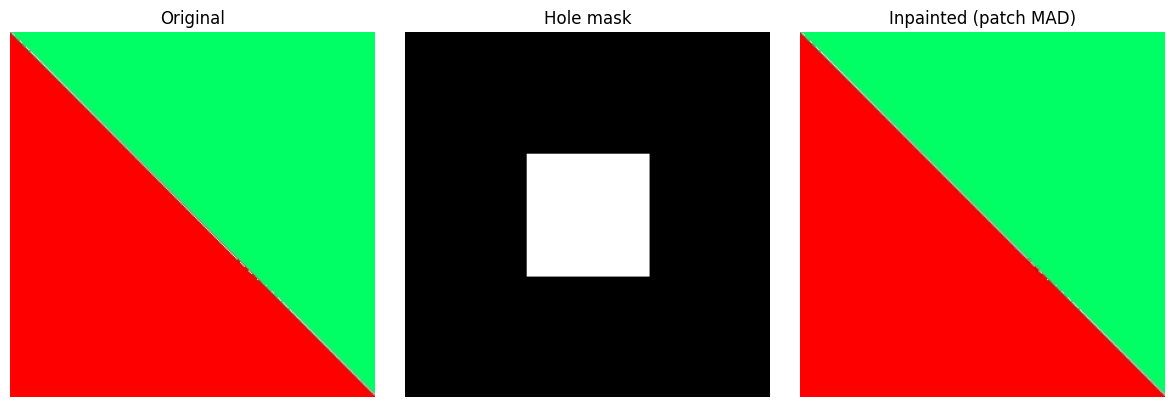

In [ ]:
k = win_r.shape[-1]
half = k // 2


inpaint_mask = cv2.bitwise_not(mask)  # <- flip if necessary

# -- Build candidate set from the known region (outside the hole)
ys_bg, xs_bg = np.where(inpaint_mask == 0)
if len(ys_bg) == 0:
    raise ValueError("No known-region pixels found. Check your mask semantics.")

# Optional downsampling of candidates for speed (stride or random).
candidate_stride = 2                   # take every Nth candidate (spatial thinning)
ys_bg = ys_bg[::candidate_stride]
xs_bg = xs_bg[::candidate_stride]

# Or additionally limit to a random subset:
max_candidates = 1200                  # cap for speed; raise for better quality
if len(ys_bg) > max_candidates:
    idx = np.random.choice(len(ys_bg), size=max_candidates, replace=False)
    ys_bg, xs_bg = ys_bg[idx], xs_bg[idx]

# Pre-fetch candidate *patches* for all three channels (shape: M, k, k)
cand_r = win_r[ys_bg, xs_bg].astype(np.float32)
cand_g = win_g[ys_bg, xs_bg].astype(np.float32)
cand_b = win_b[ys_bg, xs_bg].astype(np.float32)

# Also keep the *center pixel* values for quick assignment
center_vals_r = r[ys_bg, xs_bg]
center_vals_g = g[ys_bg, xs_bg]
center_vals_b = b[ys_bg, xs_bg]

# Prepare output images; start from originals, we’ll only overwrite the hole
r_out = r.copy()
g_out = g.copy()
b_out = b.copy()

# coordinate middle to fill mask 
ys_t, xs_t = np.where(inpaint_mask > 0)

# Optional: shuffle to avoid streaks
order = np.arange(len(ys_t))
np.random.shuffle(order)
ys_t, xs_t = ys_t[order], xs_t[order]

# --- Inpaint each target pixel ---
for (ty, tx) in zip(ys_t, xs_t):
    # target patch kernel to reference 
    t_r = win_r[ty, tx].astype(np.float32)
    t_g = win_g[ty, tx].astype(np.float32)
    t_b = win_b[ty, tx].astype(np.float32)

    # mean distance 
    d_r = np.mean(np.abs(cand_r - t_r), axis=(1, 2))
    d_g = np.mean(np.abs(cand_g - t_g), axis=(1, 2))
    d_b = np.mean(np.abs(cand_b - t_b), axis=(1, 2))

    #best index/channel
    ir = int(np.argmin(d_r))
    ig = int(np.argmin(d_g))
    ib = int(np.argmin(d_b))

    #fillinf
    r_out[ty, tx] = center_vals_r[ir]
    g_out[ty, tx] = center_vals_g[ig]
    b_out[ty, tx] = center_vals_b[ib]


inpainted_bgr = cv2.merge([b_out, g_out, r_out])

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(cv2.merge([b,g,r]), cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(inpaint_mask, cmap="gray"); plt.title("Hole mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2RGB)); plt.title("Inpainted (patch MAD)"); plt.axis("off")
plt.tight_layout(); plt.show()

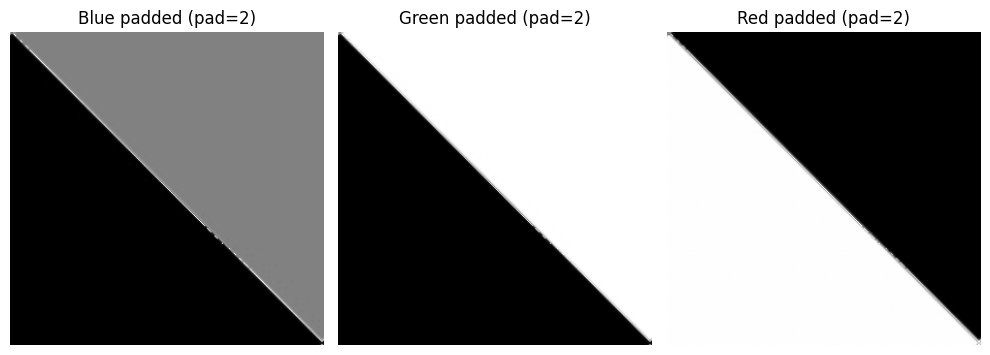

In [54]:
pad = k // 2

r_pad = cv2.copyMakeBorder(r, pad, pad, pad, pad, borderType=cv2.BORDER_REFLECT)
g_pad = cv2.copyMakeBorder(g, pad, pad, pad, pad, borderType=cv2.BORDER_REFLECT)
b_pad = cv2.copyMakeBorder(b, pad, pad, pad, pad, borderType=cv2.BORDER_REFLECT)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(b_pad, cmap="gray"); plt.title(f"Blue padded (pad={pad})"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(g_pad, cmap="gray"); plt.title(f"Green padded (pad={pad})"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(r_pad, cmap="gray"); plt.title(f"Red padded (pad={pad})"); plt.axis("off")
plt.tight_layout()
plt.show()

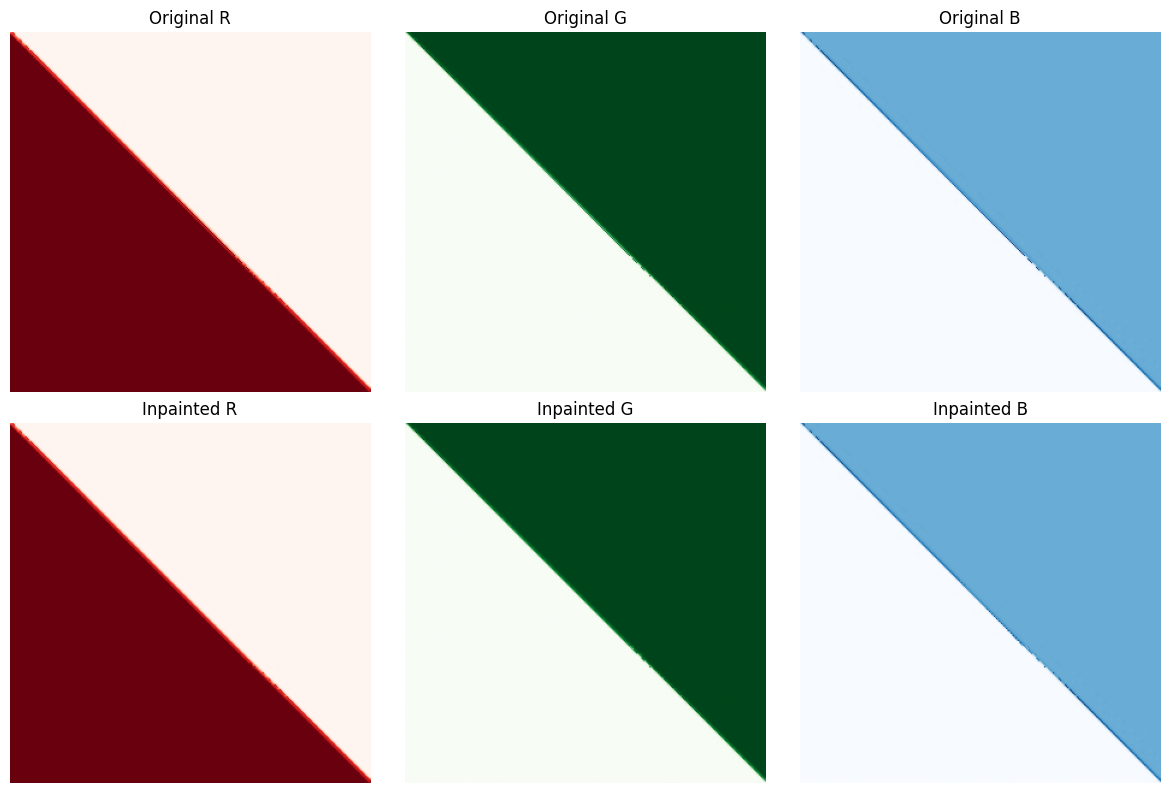

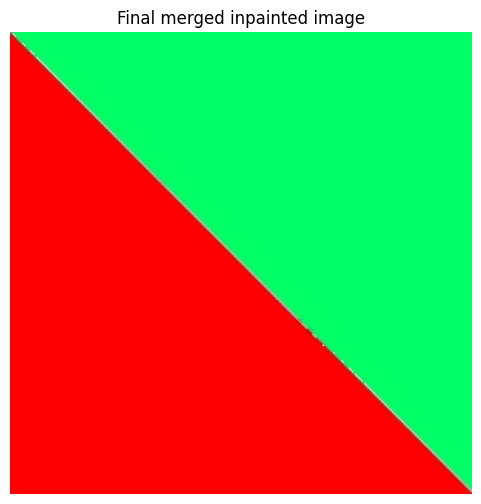

In [53]:
# === Visualize R/G/B channels before merging ===

plt.figure(figsize=(12,8))

# Original channels
plt.subplot(2,3,1)
plt.imshow(r, cmap="Reds"); plt.title("Original R"); plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(g, cmap="Greens"); plt.title("Original G"); plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(b, cmap="Blues"); plt.title("Original B"); plt.axis("off")

# Inpainted channels
plt.subplot(2,3,4)
plt.imshow(r_out, cmap="Reds"); plt.title("Inpainted R"); plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(g_out, cmap="Greens"); plt.title("Inpainted G"); plt.axis("off")

plt.subplot(2,3,6)
plt.imshow(b_out, cmap="Blues"); plt.title("Inpainted B"); plt.axis("off")

plt.tight_layout()
plt.show()


inpainted_bgr = cv2.merge([b_out, g_out, r_out])

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2RGB))
plt.title("Final merged inpainted image")
plt.axis("off")
plt.show()
